# How does energy consumption vary across the city of Chicago?
## Stephen Steiner

In this project, I will look at how energy consumption varies with the seasons, location in the city, age of the building, and price. I plan to perform basic regression analyses to determine these relationships and also plan to look at the elasticities of price and temperature.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log as ln
import geopandas 
from shapely.geometry import Point
# from pandas_datareader import data, wb
import patsy                           
import statsmodels.api as sm        
import statsmodels.formula.api as smf
import linearmodels.iv as iv   
from linearmodels import PanelOLS as pan

In [2]:
# Import and clean data on Chicago energy consumption.

energy = pd.read_csv('Energy_Usage_2010.csv', low_memory=False, thousands=',')

energy.columns = map(str.lower, energy.columns)
energy.rename(columns={'community area name':'community', 'total population':'pop', 
                       'term april 2010':'therm_apr', 'therm january 2010':'therm_jan', 
                       'therm february 2010':'therm_feb', 'therm march 2010':'therm_mar', 
                       'therm may 2010':'therm_may', 'therm june 2010':'therm_jun', 
                       'therm july 2010':'therm_jul', 'therm august 2010':'therm_aug', 
                       'therm september 2010':'therm_sep', 'therm october 2010':'therm_oct',
                       'therm november 2010':'therm_nov', 'therm december 2010':'therm_dec',
                       'kwh april 2010':'kwh_apr', 'kwh january 2010':'kwh_jan', 
                       'kwh february 2010':'kwh_feb', 'kwh march 2010':'kwh_mar', 
                       'kwh may 2010':'kwh_may', 'kwh june 2010':'kwh_jun', 
                       'kwh july 2010':'kwh_jul', 'kwh august 2010':'kwh_aug', 
                       'kwh september 2010':'kwh_sep', 'kwh october 2010':'kwh_oct',
                       'kwh november 2010':'kwh_nov', 'kwh december 2010':'kwh_dec',
                       'total kwh':'total_kwh', 'total therms':'total_therms',
                       'average stories':'avg_stories', 'average building age':'avg_build_age', 
                       'building type':'build_type', 'average housesize':'avg_housesize',
                       'occupied units':'occ_units', 'occupied units percentage':'occ_units_pct', 
                       'occupied housing units':'occ_house', 'kwh total sqft':'kwh_sqft',
                       'therms total sqft': 'therm_sqft', 'therms sqft mean 2010':'therm_sqftmean', 
                       'kwh sqft mean 2010':'kwh_sqftmean', 'kwh sqft standard deviation 2010':'kwh_sqftstd',
                       'therms sqft standard deviation 2010':'therm_sqftstd'}, inplace=True)

energy['tot_kwh_percap'] = energy['total_kwh']/energy['pop']
energy['tot_therm_percap'] = energy['total_therms']/energy['pop']

energy['tot_kwh_percap'] = energy['tot_kwh_percap'].replace(np.inf, np.nan)
energy['tot_therm_percap'] = energy['tot_therm_percap'].replace(np.inf, np.nan)

energy['community'] = energy['community'].str.lower()
energy['community'] = energy['community'].str.replace("\'", "")

energy['community'].unique()

array(['archer heights', 'ashburn', 'auburn gresham', 'austin',
       'avondale', 'belmont cragin', 'beverly', 'bridgeport',
       'brighton park', 'chatham', 'chicago lawn', 'clearing', 'dunning',
       'east garfield park', 'east side', 'edgewater', 'edison park',
       'englewood', 'gage park', 'garfield ridge', 'grand boulevard',
       'greater grand crossing', 'hermosa', 'humboldt park', 'hyde park',
       'irving park', 'jefferson park', 'lakeview', 'lincoln park',
       'lincoln square', 'logan square', 'near north side', 'loop',
       'lower west side', 'mckinley park', 'montclare', 'morgan park',
       'near west side', 'new city', 'north center', 'north lawndale',
       'north park', 'norwood park', 'ohare', 'oakland', 'portage park',
       'pullman', 'riverdale', 'rogers park', 'roseland', 'south chicago',
       'south lawndale', 'south shore', 'uptown', 'west englewood',
       'west garfield park', 'west lawn', 'albany park', 'fuller park',
       'west ridge',

## Here is where I start making the maps that will show the kwh and therms consumed in the months of August and December.

In [3]:
# Read in the map for the Chicago communities

chicago_map = geopandas.read_file('Boundaries - Community Areas (current)/geo_export_afe8915c-ab07-4bae-af48-b8f605c7f92f.shp')
chicago_map['community'] = [com.lower().replace("'", "") for com in chicago_map['community']]

chicago_map['community'] = chicago_map['community'].str.replace("lake view", "lakeview")

In [4]:
# Change the census block data in 'energy' from float to string
# Merge energy with the map of Chicago

energy2 = energy.copy()

energy2['census block'] = energy2['census block'].astype(str)
energy2['census block'] = [chic[:-2] for chic in energy2['census block']]

energy_chicago = pd.merge(left=chicago_map, right=energy2, on='community', how='outer')

energy_comms = energy_chicago[(energy_chicago['census block']=='n')]

energy_comms.tail()


,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,...,avg_stories,avg_build_age,avg_housesize,occ_units,occ_units_pct,renter-occupied housing units,renter-occupied housing percentage,occ_house,tot_kwh_percap,tot_therm_percap
64579,0.0,74,74,0.0,0.0,mount greenwood,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706...",...,1.39,48.54,211.79,2448.0,0.9477,555.0,0.2267,2448.0,849.331528,71.491636
64962,0.0,75,75,0.0,0.0,morgan park,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685...",...,1.38,49.21,584.11,4596.0,0.8823,1644.0,0.3577,4596.0,1022.952444,77.864394
65572,0.0,76,76,0.0,0.0,ohare,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",...,2.62,29.89,92.88,4912.0,0.9170,2711.0,0.5519,4912.0,1429.296573,91.664768
65720,0.0,77,77,0.0,0.0,edgewater,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",...,3.05,58.34,495.13,20530.0,0.8968,13273.0,0.6465,20530.0,1330.801413,78.222711
66728,0.0,9,9,0.0,0.0,edison park,0.0,3.163631e+07,25937.226841,"POLYGON ((-87.80676 42.00084, -87.80676 42.000...",...,1.57,46.21,188.86,2599.0,0.9369,1233.0,0.4744,2599.0,1155.937066,104.523294


In [5]:
# Create dataframes for maps

energy_aug = energy_comms[['community', 'kwh_aug', 'therm_aug', 'pop', 'perimeter', 'shape_area', 'shape_len', 'geometry']]
energy_aug2 = energy_aug.copy()
energy_aug2['kwh_per_cap'] = energy_aug2['kwh_aug']/energy_aug['pop']
energy_aug2['therm_per_cap'] = energy_aug2['therm_aug']/energy_aug['pop']

energy_dec = energy_comms[['community', 'kwh_dec', 'therm_dec', 'pop', 'perimeter', 'shape_area', 'shape_len', 'geometry']]
energy_dec2 = energy_dec.copy()
energy_dec2['kwh_per_cap'] = energy_dec2['kwh_dec']/energy_dec['pop']
energy_dec2['therm_per_cap'] = energy_dec2['therm_dec']/energy_dec['pop']

In [6]:
# Average energy consumption in the Loop and Near West Side over the course of 2010.
# Note that 'kwh_sqft' and 'therm_sqft' merely refer to the sqft associated with each activity
#  while '_sqftmean' refers to the average energy consumption in any given month of the year.

loop = energy2[(energy2['community']=='loop') & (energy2['census block']=='n')]
near_ws = energy2[(energy2['community']=='near west side') & (energy2['census block']=='n')]

print(loop[['total_kwh', 'kwh_aug', 'kwh_dec', 'kwh_sqft', 'therm_sqft', 'therm_sqftmean', 'kwh_sqftmean']])
near_ws[['kwh_aug', 'kwh_dec', 'kwh_sqft', 'therm_dec', 'therm_aug', 'therm_sqft', 'therm_sqftmean', 'kwh_sqftmean']]

         total_kwh     kwh_aug     kwh_dec    kwh_sqft  therm_sqft  \
38439  583174732.0  48097101.0  62344363.0  48592746.0  45511769.0   

       therm_sqftmean  kwh_sqftmean  
38439        679280.1      631074.6  


,kwh_aug,kwh_dec,kwh_sqft,therm_dec,therm_aug,therm_sqft,therm_sqftmean,kwh_sqftmean
42085,51589125.0,40901987.0,28610030.0,5796167.0,1731502.0,21595315.0,60322.11,82927.62


In [7]:
energy_comms[energy_comms['kwh_sqftmean']>300000]

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,...,avg_stories,avg_build_age,avg_housesize,occ_units,occ_units_pct,renter-occupied housing units,renter-occupied housing percentage,occ_house,tot_kwh_percap,tot_therm_percap
33215,0.0,33,33,0.0,0.0,near south side,0.0,4.976964e+07,45053.165104,"POLYGON ((-87.60914 41.84469, -87.60938 41.845...",...,4.09,28.30,40.64,6141.0,0.8769,4802.0,0.7820,6141.0,18412.231292,203.905919
35380,0.0,32,32,0.0,0.0,loop,0.0,4.633557e+07,39428.672996,"POLYGON ((-87.60949 41.88940, -87.60949 41.889...",...,18.47,53.43,55.15,7578.0,0.8051,5641.0,0.7444,7578.0,42477.582635,676.070945


## I plot the kwh and therm consumption per sqft (respectively) below.

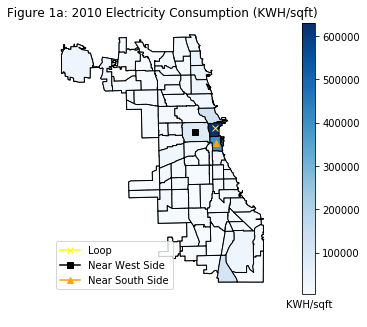

In [26]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_comms.plot(ax=gax, edgecolor='black', column='kwh_sqftmean', legend=True, cmap='Blues')

gax.set_title('Figure 1a: 2010 Electricity Consumption (KWH/sqft)')

gax.annotate('KWH/sqft', xy=(0.78, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Black', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Orange', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

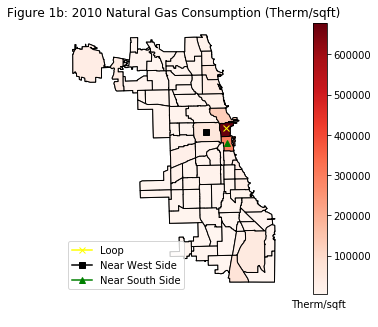

In [27]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_comms.plot(ax=gax, edgecolor='black', column='therm_sqftmean', legend=True, cmap='Reds')

gax.set_title('Figure 1b: 2010 Natural Gas Consumption (Therm/sqft)')

gax.annotate('Therm/sqft', xy=(0.77, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Black', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

### Below, I plot the energy consumption in communities across the city of Chicago.

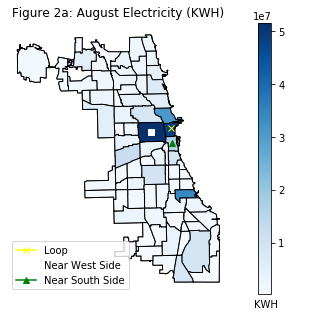

In [31]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_aug2.plot(ax=gax, edgecolor='black', column='kwh_aug', legend=True, cmap='Blues')

gax.set_title('Figure 2a: August Electricity (KWH)')

gax.annotate('KWH', xy=(0.815, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='White', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

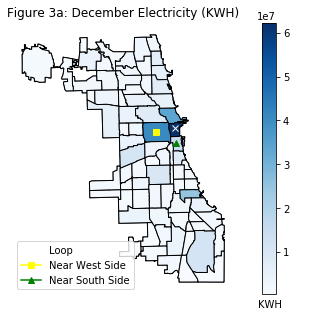

In [32]:
fig, gax = plt.subplots(figsize=(10, 5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_dec2.plot(ax=gax, edgecolor='black', column='kwh_dec', legend=True, cmap='Blues')

gax.set_title('Figure 3a: December Electricity (KWH)')

gax.annotate('KWH', xy=(0.815, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='White', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

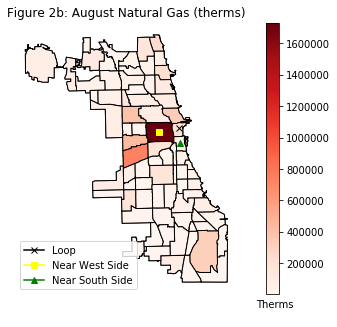

In [36]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_aug2.plot(ax=gax, edgecolor='black', column='therm_aug', legend=True, cmap='Reds')

gax.set_title('Figure 2b: August Natural Gas (therms)')

gax.annotate('Therms', xy=(0.76, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Black', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

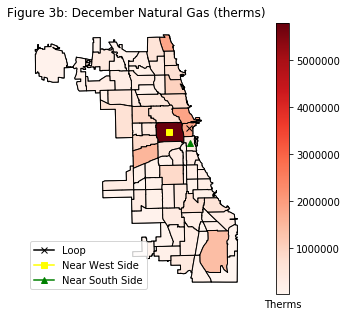

In [37]:
fig, gax = plt.subplots(figsize=(10, 5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_dec2.plot(ax=gax, edgecolor='black', column='therm_dec', legend=True, cmap='Reds')

gax.set_title('Figure 3b: December Natural Gas (therms)')

gax.annotate('Therms', xy=(0.76, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Black', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

## Next, I show how KWH/therm consumption per squarefoot varies between the three building types. I omit Industrial for most of my analysis because the data lacks sufficient observations to make meaningful claims regarding price and temperature coefficients. I also decided to split up commercial and residential demand into separate analyses because their demands are fundamentally different, shown below by the bar graph. Commercial energy requirements are far larger than those for residential energy which would suggest that they have a different demand.

In [14]:
# Here, I create residential, commercial, and industrial shares of building types. 

energy_noagg = energy2[(energy2['census block']!='n') & ~(energy2['total_kwh'].isnull())]

energy_noagg_gpd = energy_noagg.groupby(['build_type']).mean()

energy_noagg_gpd['kwh_sqftmean']

build_type
Commercial     21705.936650
Industrial     21538.000000
Residential     2987.307567
Name: kwh_sqftmean, dtype: float64

In [15]:
energy_noagg_gpd.reset_index(inplace=True)

energy_noagg_gpd1 = energy_noagg_gpd[['build_type', 'kwh_sqftmean']]
energy_noagg_gpd2 = energy_noagg_gpd[['build_type', 'therm_sqftmean']]

kwh_melt = energy_noagg_gpd1.melt(id_vars=['build_type'])
therm_melt = energy_noagg_gpd2.melt(id_vars=['build_type'])

print(kwh_melt)
therm_melt.head()

    build_type      variable         value
0   Commercial  kwh_sqftmean  21705.936650
1   Industrial  kwh_sqftmean  21538.000000
2  Residential  kwh_sqftmean   2987.307567


,build_type,variable,value
0,Commercial,therm_sqftmean,19434.809343
1,Industrial,therm_sqftmean,14401.934783
2,Residential,therm_sqftmean,2899.514607


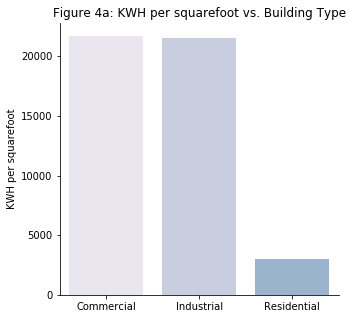

In [16]:
fig, my_ax =plt.subplots(figsize=(5, 5))

sns.barplot(x='build_type', y='value', data=kwh_melt,
           ax=my_ax, palette = sns.color_palette('PuBu'))

my_ax.set_xlabel('')
my_ax.set_ylabel('KWH per squarefoot')

my_ax.set_title('Figure 4a: KWH per squarefoot vs. Building Type')

plt.xticks(rotation='horizontal')
sns.despine(ax=my_ax)

plt.show()

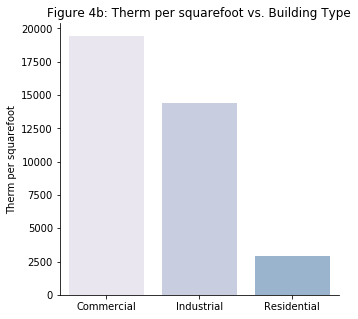

In [17]:
fig, my_ax =plt.subplots(figsize=(5, 5))

sns.barplot(x='build_type', y='value', data=therm_melt,
           ax=my_ax, palette = sns.color_palette('PuBu'))

my_ax.set_xlabel('')
my_ax.set_ylabel('Therm per squarefoot')

my_ax.set_title('Figure 4b: Therm per squarefoot vs. Building Type')

plt.xticks(rotation='horizontal')
sns.despine(ax=my_ax)

plt.show()

## I look at how average temperature affects aggregate kwh/therm consumption over the course of the year.

In [18]:
temps = pd.read_excel('avg_chicago_temps.xlsx', header=1)

prices_kwh = pd.read_excel('kwh_prices_2010.xlsx', header=9)
prices_kwh.columns = map(str.lower, prices_kwh.columns)
prices_kwh2010 = prices_kwh[prices_kwh['year']==2010]
prices_kwh2010 = prices_kwh2010.melt(id_vars={'year'})
prices_kwh2010.rename(columns={'variable':'month', 'value':'price_kwh'}, inplace=True)
prices_kwh2010.drop('year', axis=1, inplace=True)

prices_therm = pd.read_excel('therm_prices_2010.xlsx', header=1)
prices_therm.rename(columns={'price/therm':'price_therm'}, inplace=True)

prices = pd.merge(left=prices_kwh2010, right=prices_therm, on='month', how='inner')

# I decided to put the price in terms of cents rather than dollars because the changes
# in each value from month to month are small enough that expressing the values in dollars
# is not particularly helpful.

prices['price_kwh'] = prices['price_kwh']*100
prices['price_therm'] = prices['price_therm']*100

prices.head()

,month,price_kwh,price_therm
0,jan,13.6,61.83
1,feb,13.9,62.35
2,mar,13.9,66.03
3,apr,13.7,51.65
4,may,13.8,44.35


In [19]:
# Here I create variables with only one of the building types.

energy_ind = energy2[(energy2['build_type']=='Industrial') & (energy2['census block']!='n')]
energy_com = energy2[(energy2['build_type']=='Commercial') & (energy2['census block']!='n')]
energy_res = energy2[(energy2['build_type']=='Residential') & (energy2['census block']!='n')]

In [20]:
# For the next three cells, I clean, prep, and merge the residential KWH and therm data for analysis.
# I split KWH and therm data before merging them once again because their sqft data is different.

res_kwh = energy_res[['census block', 'community', 'kwh_jan', 'kwh_feb', 'kwh_mar',
                          'kwh_apr', 'kwh_may', 'kwh_jun', 'kwh_jul', 'kwh_aug', 'kwh_sep',
                          'kwh_oct', 'kwh_nov', 'kwh_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft']]

res_kwh = res_kwh.dropna()

res_kwhmlt = res_kwh.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft'})

res_kwhmlt.rename(columns={'variable':'month', 'value':'res_kwh'}, inplace=True)
res_kwhmlt = res_kwhmlt.replace({'kwh_jan':'jan', 'kwh_feb':'feb', 'kwh_mar':'mar', 'kwh_apr':'apr', 
              'kwh_may':'may', 'kwh_jun':'jun', 'kwh_jul':'jul', 'kwh_aug':'aug', 
              'kwh_sep':'sep', 'kwh_oct':'oct', 'kwh_nov':'nov', 'kwh_dec':'dec'})

res_kwh2 = pd.merge(left=res_kwhmlt, right=temps, on='month', how='left')
res_kwh2 = pd.merge(left=res_kwh2, right=prices, on='month', how='left')

res_kwh2['res_kwh_sqft'] = res_kwh2['res_kwh'] / res_kwh2['kwh_sqft']

res_kwh2 = res_kwh2[res_kwh2['res_kwh']>0]

res_kwh2.head()

,occ_units_pct,occ_house,kwh_sqft,community,occ_units,pop,avg_stories,census block,avg_build_age,month,res_kwh,avg_temp,price_kwh,price_therm,res_kwh_sqft
0,0.9254,62.0,10892.0,ashburn,62.0,112.0,2.0,170317005014004,41.0,jan,7334.0,22,13.6,61.83,0.673338
1,0.8710,27.0,4500.0,austin,27.0,79.0,3.0,170312521011000,99.0,jan,2461.0,22,13.6,61.83,0.546889
3,0.8955,60.0,9012.0,chatham,60.0,144.0,3.0,170314401011011,47.0,jan,7542.0,22,13.6,61.83,0.836884
5,0.6552,19.0,8121.0,chicago lawn,19.0,61.0,2.0,170316609002002,43.0,jan,828.0,22,13.6,61.83,0.101958
6,0.9079,69.0,5182.0,clearing,69.0,114.0,3.0,170316406002023,39.0,jan,4632.0,22,13.6,61.83,0.893863


In [21]:
res_therm = energy_res[['census block', 'community', 'therm_jan', 'therm_feb', 'therm_mar',
                          'therm_apr', 'therm_may', 'therm_jun', 'therm_jul', 'therm_aug', 'therm_sep',
                          'therm_oct', 'therm_nov', 'therm_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft']]

res_therm = res_therm.dropna()

res_thermmlt = res_therm.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft'})

res_thermmlt.rename(columns={'variable':'month', 'value':'res_therm'}, inplace=True)
res_thermmlt = res_thermmlt.replace({'therm_jan':'jan', 'therm_feb':'feb', 'therm_mar':'mar', 'therm_apr':'apr', 
              'therm_may':'may', 'therm_jun':'jun', 'therm_jul':'jul', 'therm_aug':'aug', 
              'therm_sep':'sep', 'therm_oct':'oct', 'therm_nov':'nov', 'therm_dec':'dec'})

res_therm2 = pd.merge(left=res_thermmlt, right=temps, on='month', how='left')
res_therm2 = pd.merge(left=res_therm2, right=prices, on='month', how='left')

res_therm2['res_therm_sqft'] = res_therm2['res_therm'] / res_therm2['therm_sqft']

res_therm2 = res_therm2[res_therm2['res_therm']>0]

res_therm2.head()

,occ_units_pct,occ_house,community,occ_units,therm_sqft,pop,avg_stories,census block,avg_build_age,month,res_therm,avg_temp,price_kwh,price_therm,res_therm_sqft
0,0.9582,23.0,archer heights,23.0,11134.0,89.0,2.0,170315704001006,71.33,jan,2326.0,22,13.6,61.83,0.208910
1,0.9375,15.0,avondale,15.0,1936.0,33.0,2.0,170312109001038,101.00,jan,285.0,22,13.6,61.83,0.147211
2,1.0000,1.0,beverly,1.0,6800.0,2.0,1.0,170317205002014,51.00,jan,243.0,22,13.6,61.83,0.035735
3,0.9200,23.0,clearing,23.0,3920.0,60.0,1.0,170316404001011,0.00,jan,555.0,22,13.6,61.83,0.141582
4,1.0000,16.0,dunning,16.0,1723.0,51.0,1.0,170311703003003,79.00,jan,326.0,22,13.6,61.83,0.189205


In [22]:
res_both = pd.merge(left=res_kwh2, right=res_therm2, on=['census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'month', 'avg_temp', 'price_kwh', 'price_therm'], how='inner')

res_both.head()

,occ_units_pct,occ_house,kwh_sqft,community,occ_units,pop,avg_stories,census block,avg_build_age,month,res_kwh,avg_temp,price_kwh,price_therm,res_kwh_sqft,therm_sqft,res_therm,res_therm_sqft
0,1.0000,22.0,7524.0,lincoln park,22.0,61.0,4.0,170310705003003,12.0,jan,242.0,22,13.6,61.83,0.032164,7524.0,1093.0,0.145268
1,1.0000,18.0,5804.0,near north side,18.0,36.0,3.0,170310804001003,116.0,jan,1959.0,22,13.6,61.83,0.337526,5804.0,1016.0,0.175052
2,0.8679,138.0,6420.0,south shore,138.0,224.0,2.5,170314314003001,114.5,jan,1266.0,22,13.6,61.83,0.197196,6420.0,1353.0,0.210748
3,0.9375,60.0,48825.0,albany park,60.0,132.0,3.0,170311401001001,65.5,jan,11921.0,22,13.6,61.83,0.244158,48825.0,7247.0,0.148428
4,0.9375,60.0,3306.0,albany park,60.0,132.0,2.0,170311401001001,86.0,jan,1233.0,22,13.6,61.83,0.372958,3306.0,321.0,0.097096


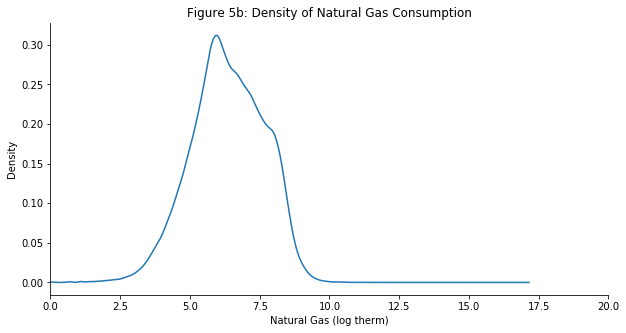

In [36]:
res_therm2.count()

fig, ax = plt.subplots(figsize=(10, 5))

res_both['res_logtherm'].plot.density(xlim=(0, 20))

ax.set_xlabel('Natural Gas (log therm)')
ax.set_ylabel('Density')

ax.set_title('Figure 5b: Density of Natural Gas Consumption')

plt.xticks(rotation='horizontal')
sns.despine(ax=ax)

plt.show()

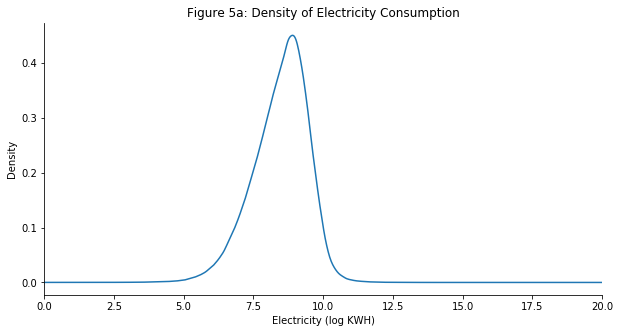

In [35]:
res_both['res_logkwh'] = ln(res_both['res_kwh'])

fig, ax = plt.subplots(figsize=(10, 5))

res_both['res_logkwh'].plot.density(ax=ax, xlim=(0, 20))

ax.set_xlabel('Electricity (log KWH)')
ax.set_ylabel('Density')

ax.set_title('Figure 5a: Density of Electricity Consumption')

plt.xticks(rotation='horizontal')
sns.despine(ax=ax)

plt.show()

In [ ]:
res_both['res_logtherm'] = ln(res_both['res_therm'])

fig, ax = plt.subplot(figsize=(10, 10))

res_both['res_logtherm'].plot.density()



In [27]:


res_temp_kwh = smf.ols('res_logkwh ~ avg_temp + avg_stories + avg_build_age', res_both).fit(cov_type='cluster', cov_kwds={'groups': res_both['community']})

print(res_temp_kwh.summary())

                            OLS Regression Results                            
Dep. Variable:             res_logkwh   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     160.8
Date:                Wed, 19 May 2021   Prob (F-statistic):           8.03e-33
Time:                        08:05:23   Log-Likelihood:            -7.6026e+05
No. Observations:              541802   AIC:                         1.521e+06
Df Residuals:                  541798   BIC:                         1.521e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.4674      0.085     99.945

In [28]:


res_temp_therm = smf.ols('res_logtherm ~ avg_temp + avg_stories + avg_build_age', res_both).fit(cov_type='cluster', cov_kwds={'groups': res_both['community']})

print(res_temp_therm.summary())

                            OLS Regression Results                            
Dep. Variable:           res_logtherm   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     4145.
Date:                Wed, 19 May 2021   Prob (F-statistic):           4.17e-84
Time:                        08:06:31   Log-Likelihood:            -7.5323e+05
No. Observations:              541802   AIC:                         1.506e+06
Df Residuals:                  541798   BIC:                         1.507e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.6793      0.079    109.791